### 거시경제지표를 추가한 주가예측 및 모멘텀투자

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bsp
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
from datetime import datetime, timedelta,date
import sys
import re
import csv
import os

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,Conv2D,RNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


### 1. 주가데이터 가져오기 & minmax 스케일

삼성생명 032830

In [2]:
os.chdir('C:\\Users\\pcsea\\work1\\Self_study\\Company_news_PJ\\total')

def stockdb(code):
    db = './{}.db'.format(code)
    with sqlite3.connect(db) as conn:
        cur=conn.cursor()
        sql='select * from stockp'
        result = cur.execute(sql).fetchall()

    return result

code = "000270"


result = stockdb(code)
df_stock = pd.DataFrame(data=result,columns=['date','open','high','low','close','vol','key'])
df_stock = df_stock.astype({'key':'str'})


#### COS_NLP
os.chdir('C:\\Users\\pcsea\\work1\\Self_study\\Company_news_PJ\\KOSPI200_NEWS\\nlp_cos\\cos')

comname = code + '_cos.csv'
df_cos = pd.read_csv(comname, encoding='utf-8')
mdata = pd.merge(df_stock, df_cos, left_on='date', right_on='sdate', how='left').sort_values(by='date').reset_index(drop=True)
oftest = mdata[mdata['polarity'].notnull()].reset_index(drop=True)['date'] 
firstoftest_d = oftest.iloc[0] 
lastoftest_d = oftest.iloc[-1] 
firstoftest_i = mdata[mdata['date']==firstoftest_d].index[0] 
lastoftest_i = mdata[mdata['date']==lastoftest_d].index[0] +1
testset = mdata[firstoftest_i:lastoftest_i]

# test기간중 뉴스기사가 없는 날의 극성을 전날 값으로 한다.
df = testset.fillna(method='ffill')
df=df.drop(columns='sdate')
df=df.drop(columns='key')
df1=df.drop(columns='polarity')

df = df1.set_index('date')


from sklearn.preprocessing import MinMaxScaler
mxs=MinMaxScaler()

# 주가 데이터 데이터프레임화 : msdf

mxs=MinMaxScaler()
mxs.fit(df)
outv=mxs.transform(df)
msdf=pd.DataFrame(outv,index=df.index,columns=df.columns)

In [3]:
df1

,date,open,high,low,close,vol,pre_por
702,2020-07-09,32950,33250,32500,32500,1154644,0.250000
703,2020-07-10,32250,32550,31900,32050,1064282,0.000000
704,2020-07-13,32300,33850,32150,33800,1924926,0.875000
705,2020-07-14,33450,34000,33100,34000,1413638,1.000000
706,2020-07-15,34800,35950,34700,35200,2955272,0.714286
...,...,...,...,...,...,...,...
816,2020-12-23,60000,62000,59500,61400,1658263,0.000000
817,2020-12-24,61800,62800,61200,61700,1271051,1.000000
818,2020-12-28,62200,63700,61700,62800,2282079,1.000000
819,2020-12-29,63600,63600,61600,62300,1839069,0.500000


In [4]:
msdf

,open,high,low,close,vol,pre_por
date,,,,,,
2020-07-09,0.021374,0.020558,0.018519,0.013493,0.043236,0.250000
2020-07-10,0.000000,0.000000,0.000000,0.000000,0.032683,0.000000
2020-07-13,0.001527,0.038179,0.007716,0.052474,0.133189,0.875000
2020-07-14,0.036641,0.042584,0.037037,0.058471,0.073481,1.000000
2020-07-15,0.077863,0.099853,0.086420,0.094453,0.253511,0.714286
...,...,...,...,...,...,...
2020-12-23,0.847328,0.864905,0.851852,0.880060,0.102048,0.000000
2020-12-24,0.902290,0.888399,0.904321,0.889055,0.056830,1.000000
2020-12-28,0.914504,0.914831,0.919753,0.922039,0.174897,1.000000


### 2. 코사인 유사도 극성 넣은 모델

In [23]:
# 경제지표 넣은 모델 돌리기

winsize=1
x_data=[]
y_data=[]

for i in range(len(msdf)-winsize):
    x_data.append(msdf.iloc[i:winsize+i,0:6])
    y_data.append(msdf.iloc[winsize+i,3])
x_data=np.array(x_data).astype('float32')
y_data=np.array(y_data).astype('float32')

train_num= int(len(y_data)*0.8)

x_train = x_data[:train_num]
x_test = x_data[train_num:]
y_train = y_data[:train_num]
y_test = y_data[train_num:]

model=Sequential()
model.add(LSTM(128,return_sequences=False, input_shape=(winsize,6,)))
model.add(Dense(64,activation ="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['cosine_proximity'])
print('predict model:', model.summary())
#mse 회귀에서 사용, 다중에선 안된다. 분류모델에만 사용?
#cosine_proximity는 안나올 수도 있다.
model.fit(x_train,y_train,epochs=30)

predict_index=model.predict(x_data)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               69120     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 77,441
Trainable params: 77,441
Non-trainable params: 0
_________________________________________________________________
predict model: None
Epoch 1/30
3/3 [==============================] - 0s 4ms/step - loss: 1.7106 - cosine_proximity: 0.8191
Epoch 2/30
3/3 [==============================] - 0s 5ms/step - loss: 0.8569 - cosine_proximity: 0.9894
Epoch 3/30
3/3 [==============================] - 0s 7ms/step - loss: 0.7266 - cosine_proximity: 0.9894
Epoch 4/30
3/3 [==============================] 

In [24]:
print( x_data.shape, '\n', y_data.shape)

(118, 1, 6) 
 (118,)


### 3. 차트만 넣은 모델

In [25]:
msdf

,open,high,low,close,vol,pre_por
date,,,,,,
2020-07-09,0.021374,0.020558,0.018519,0.013493,0.043236,0.250000
2020-07-10,0.000000,0.000000,0.000000,0.000000,0.032683,0.000000
2020-07-13,0.001527,0.038179,0.007716,0.052474,0.133189,0.875000
2020-07-14,0.036641,0.042584,0.037037,0.058471,0.073481,1.000000
2020-07-15,0.077863,0.099853,0.086420,0.094453,0.253511,0.714286
...,...,...,...,...,...,...
2020-12-23,0.847328,0.864905,0.851852,0.880060,0.102048,0.000000
2020-12-24,0.902290,0.888399,0.904321,0.889055,0.056830,1.000000
2020-12-28,0.914504,0.914831,0.919753,0.922039,0.174897,1.000000


In [26]:
# 차트만 넣은 모델 돌리기

winsize=1
x_data=[]
y_data=[]

for i in range(len(msdf)-winsize): 
    x_data.append(msdf.iloc[i:winsize+i,0:5])
    y_data.append(msdf.iloc[winsize+i,3])
x_data=np.array(x_data).astype('float32')
y_data=np.array(y_data).astype('float32')

train_num= int(len(y_data)*0.8)

x_train = x_data[:train_num]
x_test = x_data[train_num:]
y_train = y_data[:train_num]
y_test = y_data[train_num:]

model=Sequential()
model.add(LSTM(128,return_sequences=False, input_shape=(winsize,5,)))
model.add(Dense(64,activation ="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['cosine_proximity'])
print('predict model:', model.summary())

         #mse 회귀에서 사용, 다중에선 안된다. 분류모델에만 사용?
         #cosine_proximity는 안나올 수도 있다.
model.fit(x_train,y_train,epochs=30)

predict_chart=model.predict(x_data)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________
predict model: None
Epoch 1/30
3/3 [==============================] - 0s 9ms/step - loss: 1.5514 - cosine_proximity: 0.9894
Epoch 2/30
3/3 [==============================] - 0s 4ms/step - loss: 0.9679 - cosine_proximity: 0.9894
Epoch 3/30
3/3 [==============================] - 0s 9ms/step - loss: 0.8358 - cosine_proximity: 0.9894
Epoch 4/30
3/3 [==============================] 

In [9]:
len(x_test)

24

### 4. 그래프그리기

In [16]:
len(msdf[3:]['close'][train_num:])

24

In [17]:
len(predict_chart)

116

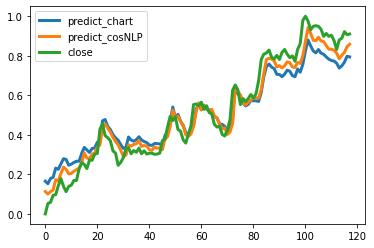

In [27]:
# 그래프 그리기

close_minmax=msdf[1:]['close'].values
# close_minmax=msdf[3:]['close'][train_num:]
# plt.figure(figsize=(10,10))

plt.plot(predict_chart ,label='predict_chart', linewidth='3')
plt.plot(predict_index ,label='predict_cosNLP',linewidth='3')
plt.plot(close_minmax ,label='close',linewidth='3')


plt.legend(prop={'size':10}, loc='best')
plt.show()

In [23]:
msdf[3:]['close']

date
2020-07-14    0.058471
2020-07-15    0.094453
2020-07-16    0.097451
2020-07-17    0.142429
2020-07-20    0.178411
                ...   
2020-12-23    0.880060
2020-12-24    0.889055
2020-12-28    0.922039
2020-12-29    0.907046
2020-12-30    0.910045
Name: close, Length: 116, dtype: float64

In [24]:
len(msdf[3:]['close'].values[3:])

113

In [25]:
len(close_minmax)

114

In [26]:
df1

,date,open,high,low,close,vol,pre_por
702,2020-07-09,32950,33250,32500,32500,1154644,0.250000
703,2020-07-10,32250,32550,31900,32050,1064282,0.000000
704,2020-07-13,32300,33850,32150,33800,1924926,0.875000
705,2020-07-14,33450,34000,33100,34000,1413638,1.000000
706,2020-07-15,34800,35950,34700,35200,2955272,0.714286
...,...,...,...,...,...,...,...
816,2020-12-23,60000,62000,59500,61400,1658263,0.000000
817,2020-12-24,61800,62800,61200,61700,1271051,1.000000
818,2020-12-28,62200,63700,61700,62800,2282079,1.000000
819,2020-12-29,63600,63600,61600,62300,1839069,0.500000


### 5. 예측한 주가로 이평선 칼럼 추가

In [27]:
close_minmax=msdf['close'].values[3:]

test_df = df1[3:][['date','open','close','vol']]
test_df = test_df.reset_index(drop=True)
test_df['close_minmax']=close_minmax
test_df['predict_chart']=predict_chart
test_df['predict_index']=predict_index

def moveline(column,n,df):
    df['{}이평{}'.format(column,n)] = df[column].rolling(window=n, min_periods=1).mean()

for i in ['close_minmax','predict_chart','predict_index']:
    for j in [1,5,10,20,60,120]:
        moveline(i,j,test_df)
        
test_df

,date,open,close,vol,close_minmax,predict_chart,predict_index,close_minmax이평1,close_minmax이평5,close_minmax이평10,...,predict_chart이평10,predict_chart이평20,predict_chart이평60,predict_chart이평120,predict_index이평1,predict_index이평5,predict_index이평10,predict_index이평20,predict_index이평60,predict_index이평120
0,2020-07-14,33450,34000,1413638,0.058471,0.096772,0.131463,0.058471,0.058471,0.058471,...,0.096772,0.096772,0.096772,0.096772,0.131463,0.131463,0.131463,0.131463,0.131463,0.131463
1,2020-07-15,34800,35200,2955272,0.094453,0.104928,0.152736,0.094453,0.076462,0.076462,...,0.100850,0.100850,0.100850,0.100850,0.152736,0.142100,0.142100,0.142100,0.142100,0.142100
2,2020-07-16,35500,35300,1891487,0.097451,0.134099,0.161528,0.097451,0.083458,0.083458,...,0.111933,0.111933,0.111933,0.111933,0.161528,0.148576,0.148576,0.148576,0.148576,0.148576
3,2020-07-17,35950,36800,2720640,0.142429,0.153662,0.184890,0.142429,0.098201,0.098201,...,0.122365,0.122365,0.122365,0.122365,0.184890,0.157654,0.157654,0.157654,0.157654,0.157654
4,2020-07-20,36950,38000,2899647,0.178411,0.178290,0.197824,0.178411,0.114243,0.114243,...,0.133550,0.133550,0.133550,0.133550,0.197824,0.165688,0.165688,0.165688,0.165688,0.165688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2020-12-23,60000,61400,1658263,0.880060,0.830008,0.824300,0.880060,0.878261,0.903748,...,0.873862,0.847854,0.669027,0.506649,0.824300,0.846988,0.860476,0.833925,0.662375,0.507435
112,2020-12-24,61800,61700,1271051,0.889055,0.820332,0.785036,0.889055,0.876462,0.897451,...,0.865547,0.849908,0.675425,0.509425,0.785036,0.830598,0.850028,0.834056,0.668133,0.509892
113,2020-12-28,62200,62800,2282079,0.922039,0.823517,0.814724,0.922039,0.880060,0.894753,...,0.857916,0.852271,0.682300,0.512180,0.814724,0.822679,0.845635,0.836718,0.674928,0.512566
114,2020-12-29,63600,62300,1839069,0.907046,0.846795,0.853632,0.907046,0.886057,0.892054,...,0.852908,0.856348,0.689722,0.515090,0.853632,0.824561,0.843168,0.842803,0.682673,0.515532


### 6. 모의투자 함수 작성

In [28]:
# 모의 투자 돌리기

def print_return(column,shortline,longline,jonbu,df):
    
    df2 = df1.loc[:,['date','close','vol']]
    df2 = df2[3:]
    df2 = df2.reset_index(drop=True)

    
    # 컬럼 추가
    df2['단기평균'] = df['{}이평{}'.format(column,shortline)]
    df2['장기평균'] = df['{}이평{}'.format(column,longline)]
    df2['거래상태']=''
    df2['주식수']=0
    df2['잔고']=0

    # 초기값 설정 (주식 가지고 있는 상태로 시작)
    pre_balance = 1000000
    balance = 1000000
    st_price = df['close'][3]
    no = balance//st_price
    er = no
    balance -= st_price*no
    
    if no > 0:
        df2.loc[0,'거래상태'] = '보유'
    df2.loc[0,'주식수'] = no
    df2.loc[0,'잔고'] = balance

    # 거래 시작
    for i in range(1,len(df2)):
        if df2['거래상태'][i-1]=='보유' or df2['거래상태'][i-1]=='매수':
            if df2['단기평균'][i-1]>=df2['장기평균'][i-1] and df2['단기평균'][i]<df2['장기평균'][i]:
                if jonbu == 1:
                    profit = df2['close'][i]-st_price
                    if profit > 0:
                        df2.loc[i,'거래상태'] = '매도'
                        balance += df2['close'][i]*no
                        no = 0
                    else:
                        df2.loc[i,'거래상태'] = '보유'
                else:
                    df2.loc[i,'거래상태'] = '매도'
                    balance += df2['close'][i]*no
                    no = 0
            else:
                df2.loc[i,'거래상태'] = '보유'
        elif df2['거래상태'][i-1]=='매도' or df2['거래상태'][i-1]=='':
            if df2['단기평균'][i-1]<=df2['장기평균'][i-1] and df2['단기평균'][i]>df2['장기평균'][i]:
                if df2['잔고'][i-1] > df2['close'][i]:
                    df2.loc[i,'거래상태'] = '매수'
                    st_price = df2['close'][i]
                    no = balance//st_price
                    balance -= st_price*no
                else:
                    df2.loc[i,'거래상태'] = ''
        df2.loc[i,'주식수'] = no
        df2.loc[i,'잔고'] = balance

    # 수익 도출

    return_trade = df2['close'][len(df2)-1]*no+df2['잔고'][len(df2)-1]- pre_balance # 매매거래o
    return_no_trade = (df2['close'][len(df2)-1]-df2['close'][0])*er # 매매거래x

    return df2, return_trade, return_no_trade


### 7. 모의투자 수익률 DF 만들기

In [29]:
test_df_return = pd.DataFrame(columns=['거래X','존버X','존버O'])

for column in ['close_minmax','predict_chart','predict_index']:
    for shortline in [1,5,10,20,60,120]:
        for longline in [5,10,20,60,120]:
            if shortline<longline:
                
                index = str(column)+'/'+str(shortline)+'&'+str(longline)
                print(index)
                
                test_df_return.loc[index, '거래X'] = print_return(column,shortline,longline,0,test_df)[2]
                test_df_return.loc[index, '존버X'] = print_return(column,shortline,longline,0,test_df)[1]
                test_df_return.loc[index, '존버O'] = print_return(column,shortline,longline,1,test_df)[1]


close_minmax/1&5
close_minmax/1&10
close_minmax/1&20
close_minmax/1&60
close_minmax/1&120
close_minmax/5&10
close_minmax/5&20
close_minmax/5&60
close_minmax/5&120
close_minmax/10&20
close_minmax/10&60
close_minmax/10&120
close_minmax/20&60
close_minmax/20&120
close_minmax/60&120
predict_chart/1&5
predict_chart/1&10
predict_chart/1&20
predict_chart/1&60
predict_chart/1&120
predict_chart/5&10
predict_chart/5&20
predict_chart/5&60
predict_chart/5&120
predict_chart/10&20
predict_chart/10&60
predict_chart/10&120
predict_chart/20&60
predict_chart/20&120
predict_chart/60&120
predict_index/1&5
predict_index/1&10
predict_index/1&20
predict_index/1&60
predict_index/1&120
predict_index/5&10
predict_index/5&20
predict_index/5&60
predict_index/5&120
predict_index/10&20
predict_index/10&60
predict_index/10&120
predict_index/20&60
predict_index/20&120
predict_index/60&120


### 8. 모의투자 수익률 탑 3 구하기

In [30]:
dic = {}

for i in range(len(test_df_return)):
    for j in range(len(test_df_return.columns)):
        dic[i,j] = test_df_return.iloc[i,j]

dic_sort = sorted(dic.items(), key=lambda x: x[1], reverse=True)

top1 = dic_sort[0]
top2 = dic_sort[1]
top3 = dic_sort[2]

top1_label = test_df_return.index[top1[0][0]],test_df_return.columns[top1[0][1]]
top2_label = test_df_return.index[top2[0][0]],test_df_return.columns[top2[0][1]]
top3_label = test_df_return.index[top3[0][0]],test_df_return.columns[top3[0][1]]

(code, top1_label, top2_label, top3_label)

('000270',
 ('close_minmax/1&5', '존버O'),
 ('close_minmax/1&5', '존버X'),
 ('close_minmax/1&5', '거래X'))

In [31]:
# 마지막 숫자 = 순수익100만원 +a의 +a값
(code, top1, top2, top3)

('000270', ((0, 2), 915750), ((0, 1), 778650), ((0, 0), 766800))